## Preparing Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

The images in the MNIST dataset consist of 28x28 pixels, and each pixel is represented by a grayscale intensity value. The fetch_openml unrolls the images into rows of 28x28 columns representing each pixel.

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X, y = X.values, y.astype(int).values
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Shape of X:  (70000, 784)
Shape of y:  (70000,)


Normally, we derive scaling parameters from the training dataset and used these to scale each column in the training and test dataset. However, when working with image pixels, centering them at zero and rescaling them to a [–1, 1] range is also common and usually works well in practice.


In [3]:
# we are scaling the images on a pixel-by-pixel basis
X = ((X / 255.) - 0.5) * 2

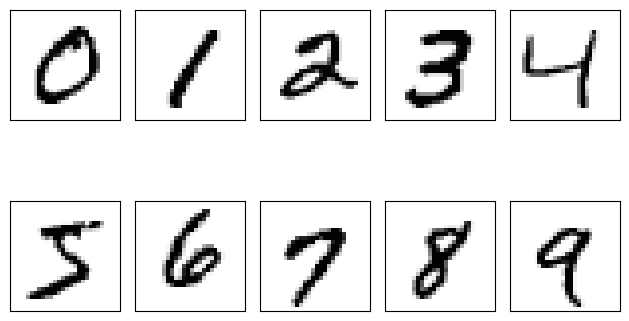

In [4]:
# Visualizing the dataset
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
  img = X[y==i][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

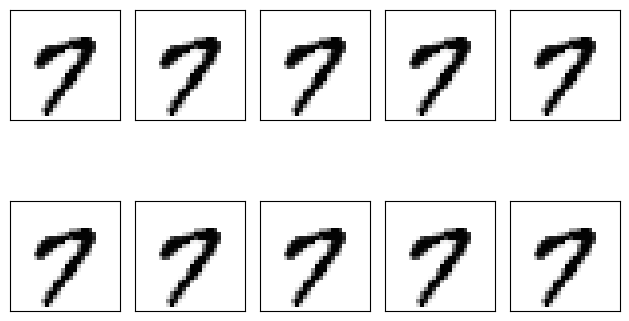

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
  img = X[y==7][0].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [6]:
# splitting the dataset into train, test and validation
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=42, stratify=y_temp)
print(f"Train set: {X_train.shape}, Validation set: {X_valid.shape}, Test set: {X_test.shape}")

Train set: (55000, 784), Validation set: (5000, 784), Test set: (10000, 784)


## Model

In [7]:
def sigmoid(z):
  return 1. / (1. + np.exp(-z))

def one_hot_encode(y, num_labels):
  arr = np.zeros((y.shape[0], num_labels))
  for i, val in enumerate(y):
    arr[i, val] = 1
  return arr

Create a single hidden layer neural network. I use sigmoid activation function and mean-squared error loss function.

In [8]:
class MLP_Net:
  def __init__(self, num_features, num_hidden_units, num_classes, random_seed=42):
    super().__init__()
    self.num_classes = num_classes

    rand_num_gen = np.random.RandomState(random_seed)

    # dim: [num_hidden, num_features]
    self.weight_h = rand_num_gen.normal(loc=0.0, scale=0.1, size=(num_hidden_units, num_features))

    # dim: [1, num_hidden]
    self.bias_h = np.zeros(num_hidden_units)

    # dim:  [n_classes, n_hidden]
    self.weight_out = rand_num_gen.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden_units))

    # dim: [1, num_classes]
    self.bias_out = np.zeros(num_classes)


  def forward(self, x):

    # dim: [n_examples, n_features].[n_features, n_hidden] = [n_examples, n_hidden]
    z_h = np.dot(x, self.weight_h.T) + self.bias_h
    a_h = sigmoid(z_h)

    # dim: [n_examples, n_hidden].[n_hidden, n_classes] = [n_examples, n_classes]
    z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
    a_out = sigmoid(z_out)

    return a_h, a_out


  def backward(self, x, a_h, a_out, y):
    y_onehot_encoded = one_hot_encode(y, num_labels=self.num_classes)

    # dim:  [n_examples, n_classes]
    d_loss_d_a_out = (2.0 * (a_out - y_onehot_encoded)) / y.shape[0]

    # dim:  [n_examples, n_classes]
    d_a_out_d_z_out = a_out * (1.0 - a_out)

    # dim:  [n_examples, n_classes]
    delta_out = d_loss_d_a_out * d_a_out_d_z_out

    # dim:  [n_examples, n_hidden]
    d_z_out_d_w_out = a_h

    # dim:  [n_classes, n_examples].[n_examples, n_hidden] =  [n_classes, n_hidden]
    d_loss_dw_out = np.dot(delta_out.T, d_z_out_d_w_out)

    # dim: [1, n_classes]
    d_loss_db_out = np.sum(delta_out, axis=0)

    # dim: [n_classes, n_hidden]
    d_z_out_d_a_h = self.weight_out

    # dim: [n_examples, n_classes].[n_classes, n_hidden] = n_examples, n_hidden]
    d_loss_d_a_h = np.dot(delta_out, d_z_out_d_a_h)

    # dim: [n_examples, n_hidden]
    d_a_h_d_z_h = a_h * (1.0 - a_h)

    # dim: [n_examples, n_features]
    d_z_h_dw_h = x

    # dim: [n_hidden, n_examples].[n_examples, n_features] = [n_hidden, n_features]
    d_loss_dw_h = np.dot((d_loss_d_a_h * d_a_h_d_z_h).T, d_z_h_dw_h)

    # dim: [1, num_hidden]
    d_loss_db_h = np.sum((d_loss_d_a_h * d_a_h_d_z_h), axis=0)

    return (d_loss_dw_out, d_loss_db_out, d_loss_dw_h, d_loss_db_h)


In [9]:
model = MLP_Net(num_features=28*28, num_hidden_units=50, num_classes=10)

## Train Loop

In [10]:
def minibatch_generator(X, y, minibatch_size):
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)
  for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
    batch_idx = indices[start_idx:start_idx + minibatch_size]
    yield X[batch_idx], y[batch_idx]

In [11]:
def mse_loss(ground_truth, predictions, num_labels=10):
  onehot_encoded_ground_truth = one_hot_encode(ground_truth, num_labels)
  return np.mean((onehot_encoded_ground_truth - predictions) ** 2)

def accuracy(ground_truths, predictions):
  return np.mean(ground_truths == predictions)

def compute_mse_and_acc(model, X, y, num_labels=10, minibatch_size=100):
  mse, correct_preds, num_examples = 0., 0, 0
  minibatch_gen = minibatch_generator(X, y, minibatch_size)
  for i, (features, targets) in enumerate(minibatch_gen):
    _, probas = model.forward(features)
    predicted_labels = np.argmax(probas, axis=1)
    one_hot_targets = one_hot_encode(targets, num_labels)
    loss = np.mean((one_hot_targets - probas) ** 2)
    correct_preds += (predicted_labels == targets).sum()
    num_examples += targets.shape[0]
    mse += loss
  mse = mse/i
  acc = correct_preds / num_examples
  return mse, acc

In [12]:
def train_loop(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
  epoch_loss = []
  epoch_train_acc = []
  epoch_valid_acc = []

  for e in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
      a_h, a_out = model.forward(X_train_mini)
      d_loss_d_w_out, d_loss_d_b_out, d_loss_d_w_h, d_loss_d_b_h = model.backward(X_train_mini, a_h, a_out, y_train_mini)

      model.weight_h -= learning_rate * d_loss_d_w_h
      model.bias_h -= learning_rate * d_loss_d_b_h
      model.weight_out -= learning_rate * d_loss_d_w_out
      model.bias_out -= learning_rate * d_loss_d_b_out

    train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
    valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)

    train_acc, valid_acc = train_acc * 100, valid_acc * 100
    epoch_train_acc.append(train_acc)
    epoch_valid_acc.append(valid_acc)
    epoch_loss.append(train_mse)

    print(f'Epoch: {e+1:03d}/{num_epochs:03d} | Train MSE: {train_mse:.2f} | Train Acc: {train_acc:.2f}% | Valid Acc: {valid_acc:.2f}%')

  return epoch_loss, epoch_train_acc, epoch_valid_acc


In [13]:
num_epochs = 50
minibatch_size = 100
np.random.seed(42)

In [14]:
epoch_loss, epoch_train_acc, epoch_valid_acc = train_loop(model, X_train, y_train, X_valid, y_valid, num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 72.24% | Valid Acc: 73.28%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.79% | Valid Acc: 86.62%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 88.23% | Valid Acc: 88.80%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.42% | Valid Acc: 90.42%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.07% | Valid Acc: 90.98%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.48% | Valid Acc: 91.28%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 90.87% | Valid Acc: 91.46%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.34% | Valid Acc: 92.02%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 91.50% | Valid Acc: 92.30%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 91.87% | Valid Acc: 92.54%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.01% | Valid Acc: 92.66%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.25% | Valid Acc: 92.88%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.35% | Valid Acc: 92.90%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.61

## Performance Metrics

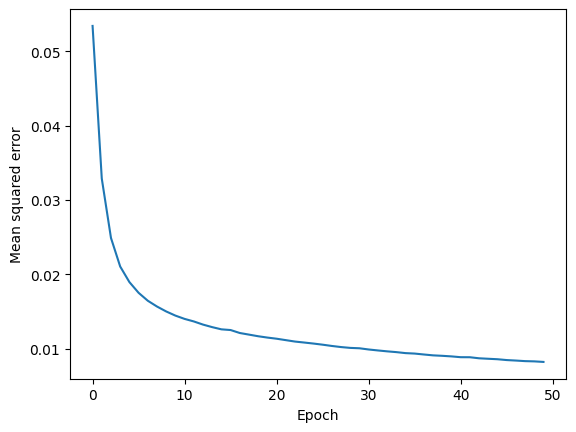

In [15]:
# Loss Curve
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel("Mean squared error")
plt.xlabel("Epoch")
plt.show()

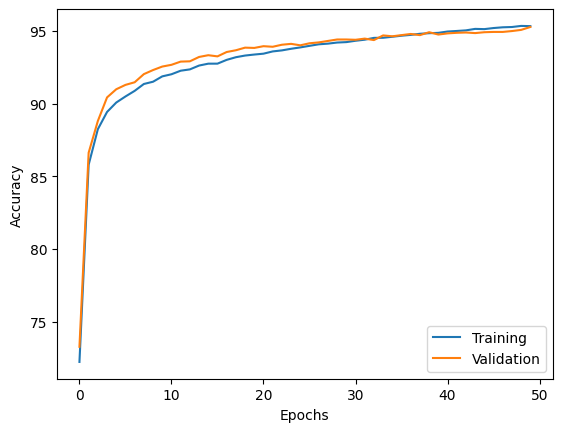

In [16]:
# Train and Validation Accuracy
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [17]:
# Test Accuracy
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.64%


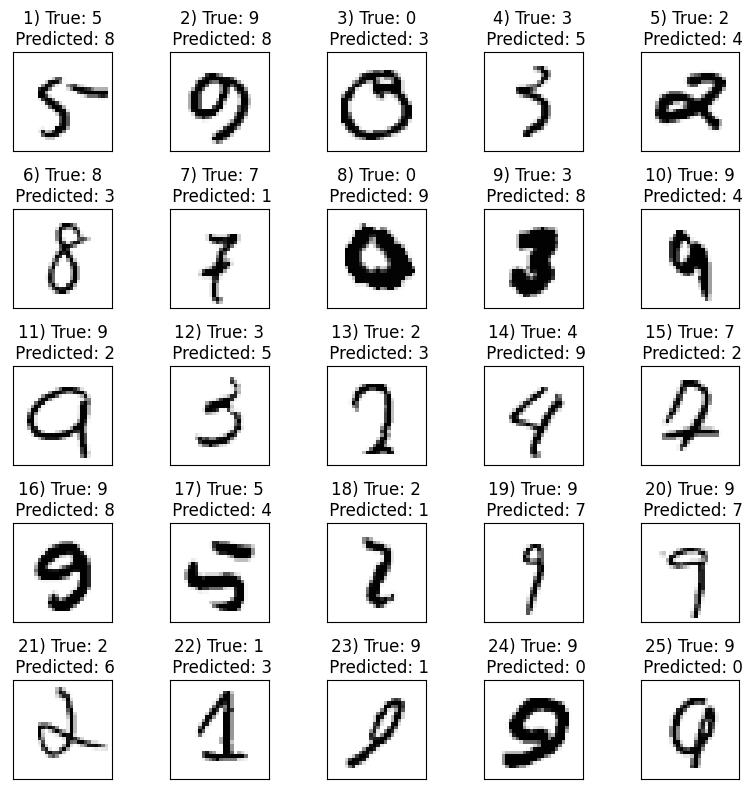

In [18]:
# Displaying the mispredicted samples
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]

misclassified_labels = test_pred[y_test_subset != test_pred][:25]

correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()

for i in range(25):
  img = misclassified_images[i].reshape(28, 28)
  ax[i].imshow(img, cmap='Greys', interpolation='nearest')
  ax[i].set_title(f'{i+1}) '
  f'True: {correct_labels[i]}\n'
  f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()